In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# 10:  Select and prune tree
https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Example%20of%20loading%20a%20custom%20tree%20model%20into%20SHAP.html

*This script takes about 1 minutes on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from pathlib import Path
import sklearn as sk
import matplotlib as mpl
import warnings
import time
import scipy
import random
from matplotlib.ticker import FormatStrFormatter, PercentFormatter
import scipy.sparse as sp
import copy, importlib

In [189]:
from PyALE import ale

In [3]:
import graphviz

In [4]:
import shap

In [5]:
import interactions_package.interactions_package

In [8]:
from interactions_package.interactions_package import ip_tree_traversal, ip_custom_tree

In [9]:
importlib.reload(ip_tree_traversal)

<module 'interactions_package.interactions_package.ip_tree_traversal' from '/Users/valeriecarey/Documents/projects/2022_12_blog_interactions/interactions_package/interactions_package/ip_tree_traversal.py'>

## Import Data

In [10]:
train_samp_df = pd.read_parquet(Path(setup.temp_path) \
                                .joinpath('03_DATA_combined_base_train_samp.parquet')) 

In [11]:
train_samp_df.shape

(100000, 35)

In [12]:
predictor_features = pd.read_csv(Path(setup.temp_path) \
                                 .joinpath('01_REPORT_predictor_features.csv')) \
    ['feature'].tolist()

## Import Simplified Tree Model

In [13]:
model_path = 'data/2023_01_25/simp_model_issue_20230501_03_tree_8_9/09_MODEL_simplified.pkl'

In [14]:
with open(model_path, 'rb') as fin:
    sel_model = pickle.load(fin)

In [592]:
#feature_list = ['int_rate', 'term', 'annual_inc']
feature_list= ['annual_inc', 'int_rate', 'term']
reduced_feature_list_5 = ['annual_inc', 'int_rate', 'term']

In [511]:
mod_tree = copy.deepcopy(sel_model.estimators_[8][0].tree_)

In [512]:
mod_tree.children_left

array([ 1,  2,  3,  4,  5, -1, -1,  8, -1, -1, 11, 12, -1, -1, 15, -1, -1,
       18, 19, 20, -1, -1, 23, -1, -1, 26, 27, -1, -1, 30, -1, -1, 33, 34,
       35, 36, -1, -1, 39, -1, -1, 42, 43, -1, -1, 46, -1, -1, 49, 50, 51,
       -1, -1, 54, -1, -1, 57, 58, -1, -1, 61, -1, -1], dtype=int64)

## ALE SHAP on this tree

In [579]:
model = sel_model.estimators_[8][0]

In [593]:
pd.Series(model.predict(train_samp_df[reduced_feature_list_5])).describe()

X has feature names, but DecisionTreeRegressor was fitted without feature names


count    100000.000000
mean         -0.052749
std           0.171749
min          -1.505114
25%          -0.148122
50%           0.009754
75%           0.066864
max           1.786827
dtype: float64

X has feature names, but DecisionTreeRegressor was fitted without feature names
X has feature names, but DecisionTreeRegressor was fitted without feature names
X has feature names, but DecisionTreeRegressor was fitted without feature names
X has feature names, but DecisionTreeRegressor was fitted without feature names
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().


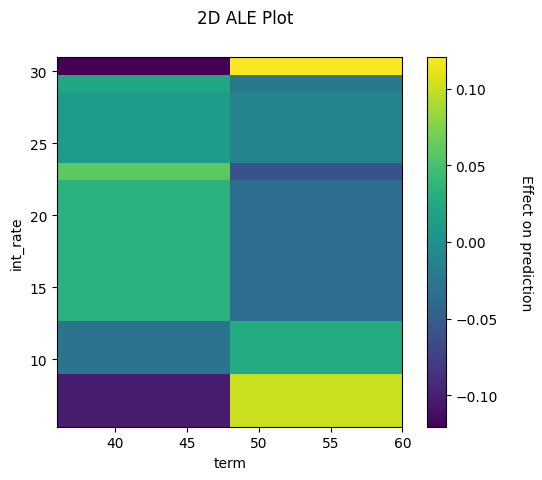

In [594]:
ale_full_tree = ale(X=train_samp_df[reduced_feature_list_5], model=model, feature=['int_rate', 'term'], plot=True)

In [596]:
explainer_full_model = shap.TreeExplainer(model, feature_names=reduced_feature_list_5)
shap_interactions_full_model =  explainer_full_model.shap_interaction_values(train_samp_df[reduced_feature_list_5])

In [583]:
model.feature_importances_

array([0.10998524, 0.81795864, 0.07205612])

In [597]:
this_shap_full = pd.concat([train_samp_df[['int_rate', 'term']].reset_index(),
                            pd.DataFrame({'shap': shap_interactions_full_model[:,1, 0]})],
                           axis=1)

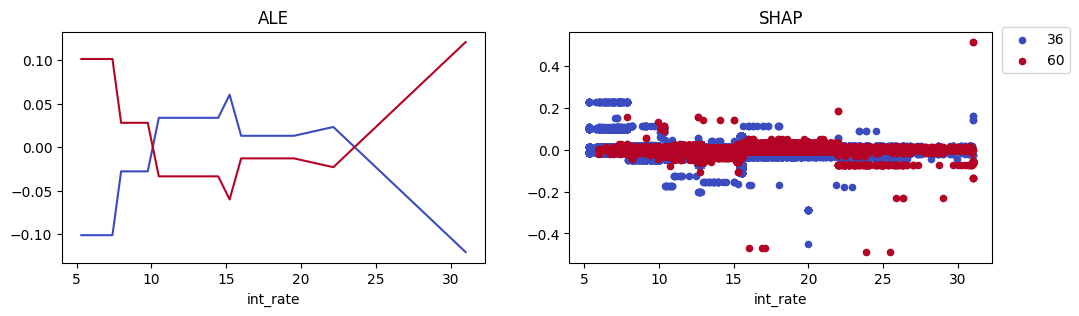

In [598]:
_ = comp_plot(ale_full_tree, this_shap_full)

## Convert entire tree to custom to test

In [513]:
tree_dict_orig = {'children_left': mod_tree.children_left.copy(),
                  'children_right': mod_tree.children_right.copy(),
                   'feature': mod_tree.feature.copy(),
                 'threshold': mod_tree.threshold.copy(),
                 'n_node_samples': mod_tree.n_node_samples.copy(),
                 'impurity': mod_tree.impurity.copy(),
                 'value': [t[0][0].copy() for t in mod_tree.value]}

In [514]:
tree_dict_template_orig = ip_custom_tree.TemplateClassifier.convert_tree_dict(tree_dict_orig)

In [515]:
temp_clas_orig = ip_custom_tree.TemplateClassifier(tree_dict_template_orig)

In [516]:
temp_clas_orig.fit(None, None)

TemplateClassifier(max_depth=7,
                   tree_dict={'children_default': array([32, 17, 10,  7,  6, -1, -1,  9, -1, -1, 14, 13, -1, -1, 16, -1, -1,
       25, 22, 21, -1, -1, 24, -1, -1, 29, 28, -1, -1, 31, -1, -1, 48, 41,
       38, 37, -1, -1, 40, -1, -1, 45, 44, -1, -1, 47, -1, -1, 56, 53, 52,
       -1, -1, 55, -1, -1, 60, 59, -1, -1, 62, -1, -1], dtype=int64),
                              'children_left': array([ 1,  2,  3,  4,  5, -1, -1,  8, -1, -1, 11, 12, -1, -1, 15, -1, -1,
       18, 19, 20, -1, -1...
       [-3.82594250e-01],
       [ 3.68938573e-01],
       [ 2.07258349e-02],
       [-4.19955666e-02],
       [ 1.36859565e-01],
       [ 3.23363181e-02],
       [ 6.16207257e-02],
       [-2.69701939e-01],
       [-1.50511424e+00],
       [-8.10477112e-01],
       [ 6.30686787e-02],
       [ 2.58619774e-01],
       [ 1.78682742e+00],
       [ 2.86794609e-02],
       [ 2.38555382e-02],
       [ 1.11903012e-01],
       [-3.55852636e-01],
       [ 4.21878675e-02],
       [ 1.85059306e-01],
       [-5.14148044e-02]])})

In [517]:
#temp_clas_orig.tree_dict['values']

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().


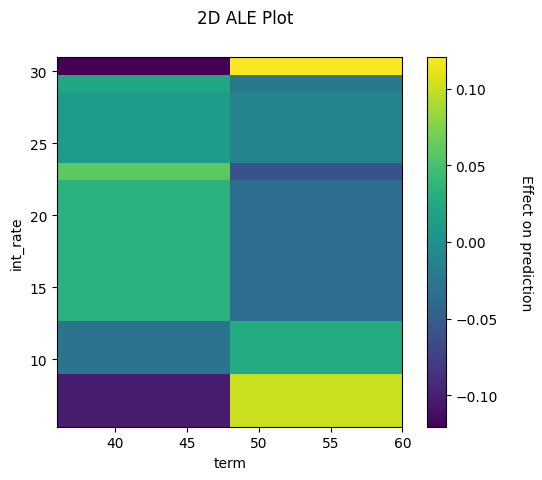

In [595]:
this_ale_orig = ale(X=train_samp_df[reduced_feature_list_5], model=temp_clas_orig, feature=['int_rate', 'term'], plot=True)

In [519]:
explainer_orig = shap.TreeExplainer(temp_clas_orig.model, feature_names=feature_list)
shap_interactions_orig =  explainer_orig.shap_interaction_values(train_samp_df[feature_list])

In [520]:
this_shap_orig = pd.concat([train_samp_df[['int_rate', 'term']].reset_index(),
                            pd.DataFrame({'shap': shap_interactions_orig[:,1, 0]})],
                           axis=1)

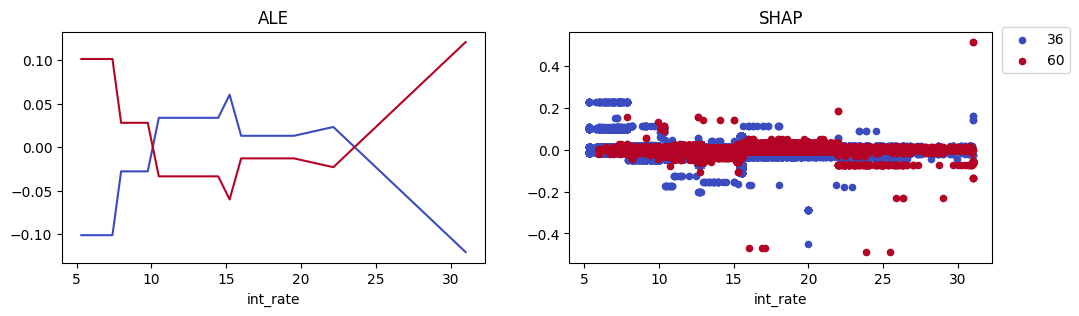

In [521]:
_ = comp_plot(this_ale_orig, this_shap_orig)

## Tree Mod

In [522]:
tree_list = list(dir(mod_tree))

In [523]:
tree_elem = []
for t in tree_list:
    t_type = type(getattr(mod_tree, t))
    if str(t_type) ==  "<class 'numpy.ndarray'>":
        t_len = len(getattr(mod_tree, t))
        if t_len == 63:
            tree_elem.append(t)
    else:
        t_len=None
    print(f'{t}: {t_type} {t_len}')
print(tree_elem)

__class__: <class 'type'> None
__delattr__: <class 'method-wrapper'> None
__dir__: <class 'builtin_function_or_method'> None
__doc__: <class 'str'> None
__eq__: <class 'method-wrapper'> None
__format__: <class 'builtin_function_or_method'> None
__ge__: <class 'method-wrapper'> None
__getattribute__: <class 'method-wrapper'> None
__getstate__: <class 'builtin_function_or_method'> None
__gt__: <class 'method-wrapper'> None
__hash__: <class 'method-wrapper'> None
__init__: <class 'method-wrapper'> None
__init_subclass__: <class 'builtin_function_or_method'> None
__le__: <class 'method-wrapper'> None
__lt__: <class 'method-wrapper'> None
__ne__: <class 'method-wrapper'> None
__new__: <class 'builtin_function_or_method'> None
__pyx_vtable__: <class 'PyCapsule'> None
__reduce__: <class 'builtin_function_or_method'> None
__reduce_ex__: <class 'builtin_function_or_method'> None
__repr__: <class 'method-wrapper'> None
__setattr__: <class 'method-wrapper'> None
__setstate__: <class 'builtin_func

In [524]:
## IMPORTTANT
# Tree elements
# ['children_left', 'children_right', 'feature', 
# 'impurity', 'n_node_samples', 'threshold', 'value', 'weighted_n_node_samples']

In [525]:
leaf_nodes = np.where(mod_tree.children_left == -1)
leaf_nodes

(array([ 5,  6,  8,  9, 12, 13, 15, 16, 20, 21, 23, 24, 27, 28, 30, 31, 36,
        37, 39, 40, 43, 44, 46, 47, 51, 52, 54, 55, 58, 59, 61, 62]),)

In [526]:
mod_tree.feature[leaf_nodes]

array([-2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2,
       -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2],
      dtype=int64)

In [527]:
mod_tree.threshold[leaf_nodes]

array([-2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2.])

In [528]:
mod_tree.impurity

array([0.14756681, 0.1199417 , 0.07428182, 0.05304517, 0.09039299,
       0.08574608, 0.10319946, 0.05161131, 0.05044601, 0.10200926,
       0.09619147, 0.09695494, 0.09381651, 0.12348037, 0.08445161,
       0.11583675, 0.07546117, 0.15089694, 0.15494598, 0.13343746,
       0.13633181, 0.13274662, 0.17191406, 0.17088618, 0.17201213,
       0.13903081, 0.12471788, 0.12505261, 0.06870011, 0.17351564,
       0.17374627, 0.16569874, 0.21503563, 0.19836489, 0.19091455,
       0.19467478, 0.18656335, 0.19869674, 0.19066763, 0.16075122,
       0.19515153, 0.22485054, 0.2318425 , 0.1751513 , 0.23276736,
       0.22338369, 0.20262554, 0.22986313, 0.23331192, 0.24650128,
       0.0656506 , 0.00071775, 0.1395863 , 0.2468098 , 0.24688296,
       0.06632653, 0.23154445, 0.22655383, 0.22662866, 0.20439914,
       0.24527202, 0.24611366, 0.22357026])

In [529]:
mod_tree.children_left

array([ 1,  2,  3,  4,  5, -1, -1,  8, -1, -1, 11, 12, -1, -1, 15, -1, -1,
       18, 19, 20, -1, -1, 23, -1, -1, 26, 27, -1, -1, 30, -1, -1, 33, 34,
       35, 36, -1, -1, 39, -1, -1, 42, 43, -1, -1, 46, -1, -1, 49, 50, 51,
       -1, -1, 54, -1, -1, 57, 58, -1, -1, 61, -1, -1], dtype=int64)

In [530]:
value_flat = np.array([c[0][0] for c in mod_tree.value])
value_flat

array([-6.99893115e-04, -1.02878937e-02, -2.15756550e-02, -2.74650648e-02,
       -3.21920119e-03, -1.10739937e-01,  1.94702718e-01, -2.83809576e-02,
       -3.82656476e-01, -5.94328686e-02, -1.54793412e-02, -1.38981691e-02,
       -1.48122239e-01,  1.35387765e-02, -3.86093842e-02, -1.19750059e-01,
       -4.06016272e-01, -2.59925552e-03,  5.33096454e-04, -5.23188958e-03,
        7.24182935e-02, -6.07849690e-02,  5.09371718e-03,  1.43042090e-01,
        1.50159096e-02, -1.16929213e-02, -1.66443417e-02, -1.18441538e-01,
       -6.49123552e-01,  3.07147985e-04,  9.75353115e-03, -2.01802311e-01,
        2.29905059e-02,  1.45425783e-02,  1.08629213e-02,  4.84986192e-02,
        9.27757001e-02,  4.19909931e-01,  9.09061837e-03, -8.43205516e-02,
        6.68641524e-02,  2.77335187e-02,  7.19628830e-02, -3.82594250e-01,
        3.68938573e-01,  2.07258349e-02, -4.19955666e-02,  1.36859565e-01,
        3.23363181e-02,  6.16207257e-02, -2.69701939e-01, -1.50511424e+00,
       -8.10477112e-01,  

In [531]:
np.where(value_flat > 1.78682741)

(array([55]),)

In [532]:
np.where(value_flat < -1.5)

(array([51]),)

In [533]:
# Function to prune a tree - find all children under a node,
# set that item's feature and threshold to -2, 
# don't need to set the node sample
# set the value to the weighted values of leaf nodes under the node to be removed
# set children left and right for the item to -1
# then remove the items from the arrays
# leave the impurity alone (what does this do?)

In [534]:
#['children_left', 'children_right', 'feature', 
# 'impurity', 'n_node_samples', 'threshold', 'value', 'weighted_n_node_samples']

## Tree Pruning

In [535]:
# Function to isolate some leaf nodes and stub out everything else

In [536]:
keep_nodes = np.concatenate((np.where(value_flat > 1.78682741)[0], np.where(value_flat < -1.5)[0]))

In [537]:
keep_nodes

array([55, 51])

In [538]:
# Function to get all nodes on the decision path to a given node

In [539]:
np.where(value_flat < -1.5)[0]

array([51])

In [540]:
type(mod_tree)

sklearn.tree._tree.Tree

In [541]:
importlib.reload(ip_tree_traversal)

<module 'interactions_package.interactions_package.ip_tree_traversal' from '/Users/valeriecarey/Documents/projects/2022_12_blog_interactions/interactions_package/interactions_package/ip_tree_traversal.py'>

In [542]:
ip_tree_traversal.get_path_nodes(mod_tree, 55)

array([ 0., 32., 48., 49., 53.])

In [543]:
include_nodes = np.unique(np.append(ip_tree_traversal.get_path_nodes(mod_tree, 51), 
                                    ip_tree_traversal.get_path_nodes(mod_tree, 55)))
include_nodes

array([ 0., 32., 48., 49., 50., 53.])

In [544]:
# Function to create a new tree from an old, retaining only the leaves of interest.
#Traverse the tree and fill in arrays only on path

In [545]:
dummy_feature_index = -2
dummy_threshold = -2
leaf_index = -1

[i]: id of the left child of node i or -1 if leaf node
children_right[i]: id of the right child of node i or -1 if leaf node
feature[i]: feature used for splitting node i
threshold[i]: threshold value at node i
n_node_samples[i]: the number of training samples reaching node i
impurity[i]: the impurity at node i

In [546]:
importlib.reload(ip_tree_traversal)

<module 'interactions_package.interactions_package.ip_tree_traversal' from '/Users/valeriecarey/Documents/projects/2022_12_blog_interactions/interactions_package/interactions_package/ip_tree_traversal.py'>

In [547]:
tree_dict = ip_tree_traversal.simplify_tree_include_ary(mod_tree, include_nodes)

In [548]:
tree_dict

{'children_left': array([ 1, -1,  3, -1,  5,  6,  7, -1, -1, 10, -1, -1, -1]),
 'children_right': array([ 2, -1,  4, -1, 12,  9,  8, -1, -1, 11, -1, -1, -1]),
 'feature': array([ 1, -2,  2, -2,  0,  0,  1, -2, -2,  1, -2, -2, -2]),
 'threshold': array([ 1.53899999e+01, -2.00000000e+00,  4.80000000e+01, -2.00000000e+00,
         4.02840000e+04,  3.95000000e+03,  2.56300001e+01, -2.00000000e+00,
        -2.00000000e+00,  3.09650002e+01, -2.00000000e+00, -2.00000000e+00,
        -2.00000000e+00]),
 'n_node_samples': array([4.23772e+05, 3.01677e+05, 1.22095e+05, 6.41280e+04, 5.79670e+04,
        6.43500e+03, 2.80000e+01, 1.60000e+01, 1.20000e+01, 6.40700e+03,
        6.39300e+03, 1.40000e+01, 5.15320e+04]),
 'impurity': array([4.23772e+05, 3.01677e+05, 1.22095e+05, 6.41280e+04, 5.79670e+04,
        6.43500e+03, 2.80000e+01, 1.60000e+01, 1.20000e+01, 6.40700e+03,
        6.39300e+03, 1.40000e+01, 5.15320e+04]),
 'value': array([-6.99893115e-04, -1.02878937e-02,  2.29905059e-02,  1.45425783e

In [549]:
from sklearn.tree import DecisionTreeClassifier 

In [674]:
type(sel_model.estimators_[8][0])

sklearn.tree._classes.DecisionTreeRegressor

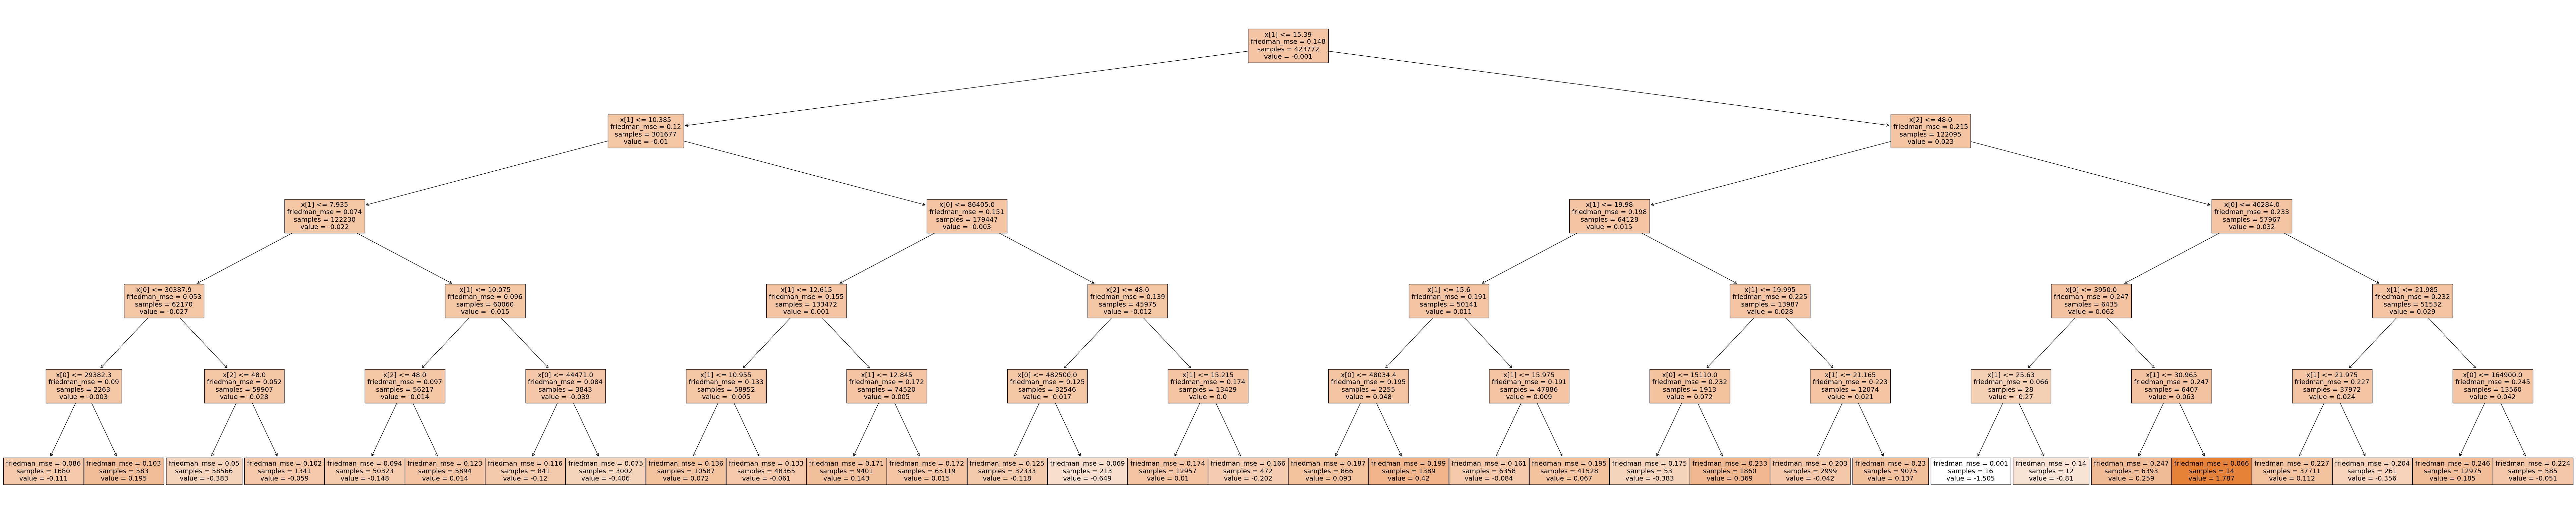

In [551]:
fig, ax = plt.subplots(figsize=(100,20))
_ = sk.tree.plot_tree(sel_model.estimators_[8][0], ax=ax, filled=True)

In [552]:
mod_est = copy.deepcopy(sel_model.estimators_[8][0])

In [553]:
mod_est.tree_.children_left

array([ 1,  2,  3,  4,  5, -1, -1,  8, -1, -1, 11, 12, -1, -1, 15, -1, -1,
       18, 19, 20, -1, -1, 23, -1, -1, 26, 27, -1, -1, 30, -1, -1, 33, 34,
       35, 36, -1, -1, 39, -1, -1, 42, 43, -1, -1, 46, -1, -1, 49, 50, 51,
       -1, -1, 54, -1, -1, 57, 58, -1, -1, 61, -1, -1], dtype=int64)

In [554]:
type(sel_model.estimators_[8][0])

sklearn.tree._classes.DecisionTreeRegressor

In [555]:
importlib.reload(

SyntaxError: '(' was never closed (2592177289.py, line 1)

In [556]:
tree_dict.keys()

dict_keys(['children_left', 'children_right', 'feature', 'threshold', 'n_node_samples', 'impurity', 'value', 'original_node_index'])

In [578]:
#dir(sel_model.estimators_[8][0])

## Create custom tree

In [951]:
importlib.reload(ip_custom_tree)

<module 'interactions_package.interactions_package.ip_custom_tree' from '/Users/valeriecarey/Documents/projects/2022_12_blog_interactions/interactions_package/interactions_package/ip_custom_tree.py'>

In [952]:
tree_dict_template = ip_custom_tree.TemplateClassifier.convert_tree_dict(tree_dict)

In [953]:
#tree_dict_template

In [954]:
importlib.reload(ip_custom_tree)

<module 'interactions_package.interactions_package.ip_custom_tree' from '/Users/valeriecarey/Documents/projects/2022_12_blog_interactions/interactions_package/interactions_package/ip_custom_tree.py'>

In [955]:
temp_clas = ip_custom_tree.TemplateClassifier(tree_dict)

In [956]:
temp_clas.fit(None, None)

TemplateClassifier(max_depth=7,
                   tree_dict={'children_left': array([ 1, -1,  3, -1,  5,  6,  7, -1, -1, 10, -1, -1, -1]),
                              'children_right': array([ 2, -1,  4, -1, 12,  9,  8, -1, -1, 11, -1, -1, -1]),
                              'feature': array([ 1, -2,  2, -2,  0,  0,  1, -2, -2,  1, -2, -2, -2]),
                              'impurity': array([4.23772e+05, 3.01677e+05, 1.22095e+05, 6.41280e+04, 5.79670e+04,
       6.43500e+03, 2.80000e+01, 1.60000e+01, 1.20000e+01, 6.40700e+0...
        4.02840000e+04,  3.95000000e+03,  2.56300001e+01, -2.00000000e+00,
       -2.00000000e+00,  3.09650002e+01, -2.00000000e+00, -2.00000000e+00,
       -2.00000000e+00]),
                              'value': array([-6.99893115e-04, -1.02878937e-02,  2.29905059e-02,  1.45425783e-02,
        3.23363181e-02,  6.16207257e-02, -2.69701939e-01, -1.50511424e+00,
       -8.10477112e-01,  6.30686787e-02,  2.58619774e-01,  1.78682742e+00,
        2.86794609e-02])})

[Text(0.375, 0.9166666666666666, 'x[1] <= 15.39\nsamples = 423772.0\nvalue = -0.001'),
 Text(0.25, 0.75, 'samples = 301677.0\nvalue = -0.01'),
 Text(0.5, 0.75, 'x[2] <= 48.0\nsamples = 122095.0\nvalue = 0.023'),
 Text(0.375, 0.5833333333333334, 'samples = 64128.0\nvalue = 0.015'),
 Text(0.625, 0.5833333333333334, 'x[0] <= 40284.0\nsamples = 57967.0\nvalue = 0.032'),
 Text(0.5, 0.4166666666666667, 'x[0] <= 3950.0\nsamples = 6435.0\nvalue = 0.062'),
 Text(0.25, 0.25, 'x[1] <= 25.63\nsamples = 28.0\nvalue = -0.27'),
 Text(0.125, 0.08333333333333333, 'samples = 16.0\nvalue = -1.505'),
 Text(0.375, 0.08333333333333333, 'samples = 12.0\nvalue = -0.81'),
 Text(0.75, 0.25, 'x[1] <= 30.965\nsamples = 6407.0\nvalue = 0.063'),
 Text(0.625, 0.08333333333333333, 'samples = 6393.0\nvalue = 0.259'),
 Text(0.875, 0.08333333333333333, 'samples = 14.0\nvalue = 1.787'),
 Text(0.75, 0.4166666666666667, 'samples = 51532.0\nvalue = 0.029')]

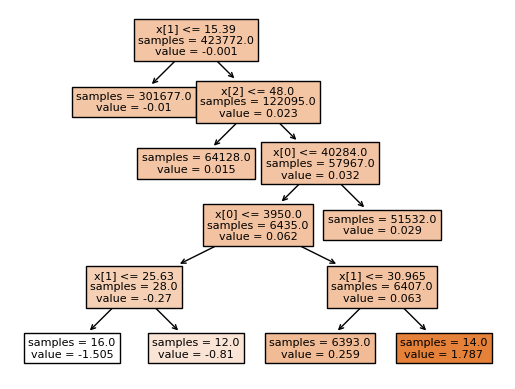

In [957]:
sk.tree.plot_tree(temp_clas, impurity=False, filled=True)

In [958]:
temp_clas.predict(train_samp_df[feature_list].iloc[0:1,:])

384468   -0.010288
dtype: float64

In [959]:
train_samp_df[feature_list].iloc[0:1,:]

,annual_inc,int_rate,term
384468,80000.0,10.91,36


In [960]:
train_samp_df[feature_list].sort_values('annual_inc', ascending=False).reset_index().iloc[0:1,:]

,index,annual_inc,int_rate,term
0,401662,10999200.0,18.06,36


In [961]:
train_samp_df[feature_list].sort_values('term', ascending=False).head(1)

,annual_inc,int_rate,term
451905,34000.0,13.67,60


In [966]:
feature_list = ['annual_inc', 'int_rate', 'term']
#feature_list = ['int_rate', 'term', 'annual_inc']
temp_clas.predict(train_samp_df[feature_list].sort_values('annual_inc', ascending=False).reset_index().iloc[0:1,:])

0    0.014543
dtype: float64

In [967]:
preds = temp_clas.predict(train_samp_df[feature_list])

In [968]:
preds.describe()

count    100000.000000
mean          0.002139
std           0.037382
min          -1.505114
25%          -0.010288
50%          -0.010288
75%           0.014543
max           1.786827
dtype: float64

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().


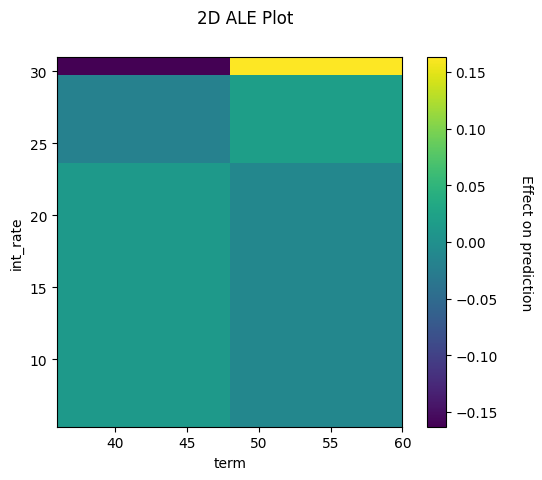

In [969]:
this_ale = ale(X=train_samp_df[feature_list], model=temp_clas, feature=['int_rate', 'term'], plot=True)

In [572]:
#opp_eff_2, ale_sign_2, ale_2, shap_2, _ = model_fit_eval(train_df, train_samp_df,
#                                                         reduced_feature_list,
#?                                                         fit_params_1)

In [573]:
temp_clas.model['trees'][0]['values']

array([[-6.99893115e-04],
       [-1.02878937e-02],
       [ 2.29905059e-02],
       [ 1.45425783e-02],
       [ 3.23363181e-02],
       [ 6.16207257e-02],
       [-2.69701939e-01],
       [-1.50511424e+00],
       [-8.10477112e-01],
       [ 6.30686787e-02],
       [ 2.58619774e-01],
       [ 1.78682742e+00],
       [ 2.86794609e-02]])

In [970]:
explainer = shap.TreeExplainer(temp_clas.model, feature_names=feature_list)
shap_interactions =  explainer.shap_interaction_values(train_samp_df[feature_list])

In [971]:
this_shap = pd.concat([train_samp_df[['int_rate', 'term']].reset_index(),
                            pd.DataFrame({'shap': shap_interactions[:,1, 0]})],
                           axis=1)

In [972]:
def comp_plot(ale_data, shap_data, color_categories = [36, 60],
             title = None):
    
    
    cmap = mpl.cm.coolwarm
    cnorm  = mpl.colors.Normalize(vmin=0, vmax= len(color_categories) -1)
    color_scalar_map = mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap)
    color_dict = {color_categories[i]: color_scalar_map.to_rgba(i) 
                  for i in range(0, len(color_categories))}
    
    fig, ax = plt.subplots(1, 2, figsize = (12,3), sharex = True)
    
    ale_data[[36, 60]].plot(legend=None, ax=ax[0], cmap=cmap)
    ax[0].set_title('ALE')
    ax[0].set_ylabel(None)

    for c in color_categories:
        shap_data[shap_data['term'] == c][['int_rate', 'shap']] \
            .plot(x='int_rate', y='shap', kind='scatter', ax=ax[1], color=color_dict[c],
                 label=c)
    ax[1].set_title('SHAP')  
    ax[1].set_ylabel(None)
    ax[1].legend(bbox_to_anchor=(1.2, 1.05))
    
    if title is not None:
        fig.suptitle(title)
    
    return fig

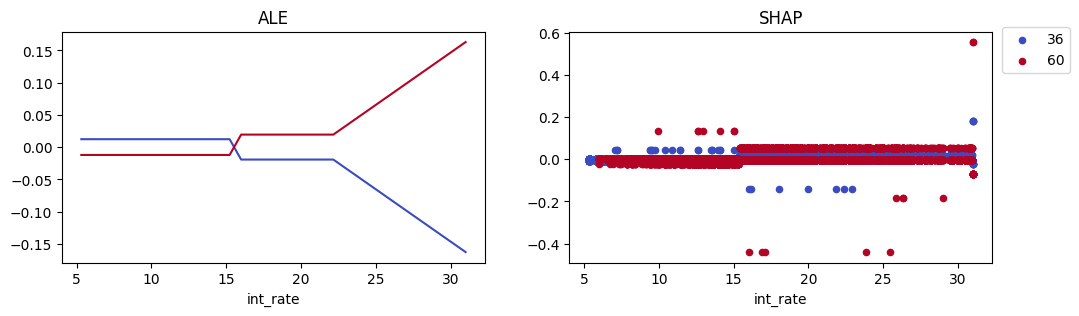

In [973]:
_ = comp_plot(this_ale, this_shap)

In [ ]:
# opposite thing?

In [605]:
reduced_feature_list_5

['annual_inc', 'int_rate', 'term']

In [611]:
trim_pair = [np.where(mod_tree.n_node_samples == 28)[0][0], np.where(mod_tree.n_node_samples == 6407)[0][0]]
trim_pair

[50, 53]

In [619]:
importlib.reload(ip_tree_traversal)

<module 'interactions_package.interactions_package.ip_tree_traversal' from '/Users/valeriecarey/Documents/projects/2022_12_blog_interactions/interactions_package/interactions_package/ip_tree_traversal.py'>

In [627]:
tree_dict2 = ip_tree_traversal.simplify_tree_leaf_dict(mod_tree, trim_pair)

In [628]:
tree_dict_template2 = ip_custom_tree.TemplateClassifier.convert_tree_dict(tree_dict2)
temp_clas2 = ip_custom_tree.TemplateClassifier(tree_dict_template2)

In [629]:
temp_clas2

TemplateClassifier(tree_dict={'children_default': array([32, 17, 10,  7,  6, -1, -1,  9, -1, -1, 14, 13, -1, -1, 16, -1, -1,
       25, 22, 21, -1, -1, 24, -1, -1, 29, 28, -1, -1, 31, -1, -1, 48, 41,
       38, 37, -1, -1, 40, -1, -1, 45, 44, -1, -1, 47, -1, -1, 52, 51, -1,
       -1, 56, 55, -1, -1, 58, -1, -1]),
                              'children_left': array([ 1,  2,  3,  4,  5, -1, -1,  8, -1, -1, 11, 12, -1, -1, 15, -1, -1,
       18, 19, 20, -1, -1, 23, -1, -1, 26, 27, -1, -1, 30, -1, -1, 33, 34...
       [ 9.09061837e-03],
       [-8.43205516e-02],
       [ 6.68641524e-02],
       [ 2.77335187e-02],
       [ 7.19628830e-02],
       [-3.82594250e-01],
       [ 3.68938573e-01],
       [ 2.07258349e-02],
       [-4.19955666e-02],
       [ 1.36859565e-01],
       [ 3.23363181e-02],
       [ 6.16207257e-02],
       [-2.69701939e-01],
       [ 6.30686787e-02],
       [ 2.86794609e-02],
       [ 2.38555382e-02],
       [ 1.11903012e-01],
       [-3.55852636e-01],
       [ 4.21878675e-02],
       [ 1.85059306e-01],
       [-5.14148044e-02]])})

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().


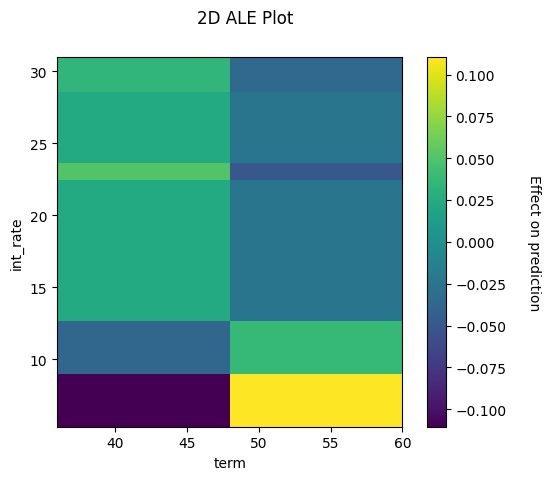

In [630]:
this_ale2 = ale(X=train_samp_df[feature_list], model=temp_clas2, feature=['int_rate', 'term'], plot=True)

In [ ]:
# So you do seem to need these!  What other ones do you need?

In [ ]:
# Try to stub out selectively
# 56, 2 OK (51532, 122230)
# 56, 1 also OK (51532, 301677 - whole left side gone)
# 56, 1, 33 OK (51532, 301677, 64128 - close around tree)
# 56, 1, 33, 56 also OK?

In [642]:
trim_list3 = [np.where(mod_tree.n_node_samples == 51532)[0][0], 
              np.where(mod_tree.n_node_samples == 301677)[0][0],
             np.where(mod_tree.n_node_samples == 64128)[0][0],
             np.where(mod_tree.n_node_samples == 51532)[0][0]]
trim_list3

[56, 1, 33, 56]

In [643]:
tree_dict3 = ip_tree_traversal.simplify_tree_leaf_dict(mod_tree, trim_list3)
tree_dict_template3 = ip_custom_tree.TemplateClassifier.convert_tree_dict(tree_dict3)
temp_clas3 = ip_custom_tree.TemplateClassifier(tree_dict_template3)

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().


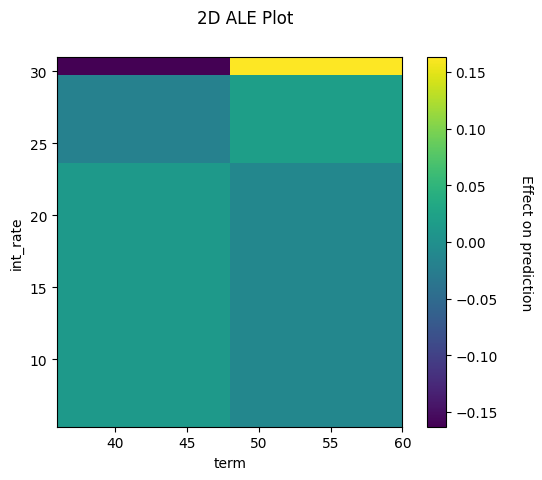

In [644]:
this_ale3 = ale(X=train_samp_df[feature_list], model=temp_clas3, feature=['int_rate', 'term'], plot=True)

In [646]:
include_nodes

array([ 0., 32., 48., 49., 50., 53.])

In [654]:
tree_dict3['original_node_index']

array([ 0,  1, 32, 33, 48, 49, 50, 51, 52, 53, 54, 55, 56])

In [655]:
tree_dict['original_node_index']

array([ 0,  1, 32, 33, 48, 49, 50, 51, 52, 53, 54, 55, 56])

In [ ]:
# Oh it did work my feature list was just not right!

In [ ]:
include_nodes = np.unique(
    
    np.append(ip_tree_traversal.get_path_nodes(mod_tree, 51), 
                                    ip_tree_traversal.get_path_nodes(mod_tree, 55)))
include_nodes

In [645]:
TODO
Custom tree functions  to define and create custom trees.
  Convert dictionary static method.
  Create object and try it
  Add plotting capabilities - modify estimator...
Make a custom tree from the trimmed dictionary and try it!  
Also figure out how to plot a custom tree, even if you have to force it to decisiontreeclassifier.
Move Shapley and ALE plotting functions, apply these

SyntaxError: invalid syntax (2957994821.py, line 2)

In [ ]:
TODO 
Try to stub out the white branch (v low inc)
Low income, high interest rate people - few have 60 term, are these different?  Different purpose etc?

In [662]:
train_samp_df['purpose'].value_counts(normalize=True)

debt_consolidation    0.57990
credit_card           0.22076
home_improvement      0.06654
other                 0.05671
major_purchase        0.02140
medical               0.01126
car                   0.01098
small_business        0.01087
moving                0.00701
vacation              0.00668
house                 0.00522
wedding               0.00173
renewable_energy      0.00069
educational           0.00025
Name: purpose, dtype: float64

In [664]:
train_samp_df[(train_samp_df['annual_inc'] <= 40000) & (train_samp_df['term'] == 60) & \
              (train_samp_df['int_rate'] > 30)]['purpose'].value_counts(normalize=True)

debt_consolidation    0.709677
credit_card           0.129032
other                 0.064516
home_improvement      0.032258
small_business        0.032258
house                 0.032258
Name: purpose, dtype: float64

In [667]:
train_samp_df[(train_samp_df['annual_inc'] <= 40000) & (train_samp_df['term'] == 60) & \
              (train_samp_df['int_rate'] > 30)]['sec_app_fico_range_low'].describe()

count     31.000000
mean     667.258065
std       34.876896
min      540.000000
25%      660.000000
50%      670.000000
75%      682.500000
max      720.000000
Name: sec_app_fico_range_low, dtype: float64

In [668]:
train_samp_df['sec_app_fico_range_low'].describe()

count    100000.000000
mean        695.557450
std          32.122528
min         540.000000
25%         670.000000
50%         690.000000
75%         710.000000
max         845.000000
Name: sec_app_fico_range_low, dtype: float64

In [669]:
train_samp_df.columns

Index(['index', 'id', 'grade', 'sub_grade', 'hardship_flag',
       'debt_settlement_flag', 'hardship_amount', 'settlement_amount',
       'addr_state', 'purpose', 'total_rec_prncp', 'total_rec_int',
       'tot_coll_amt', 'tot_cur_bal', 'application_type', 'loan_amnt', 'term',
       'int_rate', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'fico_range_low', 'sec_app_fico_range_low',
       'open_acc', 'initial_list_status', 'num_actv_bc_tl', 'mort_acc',
       'pub_rec', 'revol_bal', 'target', 'home_ownership__MORTGAGE',
       'home_ownership__RENT', 'home_ownership__OWN',
       'home_ownership__ZZ_OTHER'],
      dtype='object')

In [672]:
train_samp_df[(train_samp_df['annual_inc'] <= 40000) & (train_samp_df['term'] == 60) & \
              (train_samp_df['int_rate'] > 30)]['application_type'].value_counts(normalize=True)

0    0.612903
1    0.387097
Name: application_type, dtype: float64

In [673]:
train_samp_df['application_type'].value_counts(normalize=True)

0    0.98082
1    0.01918
Name: application_type, dtype: float64

In [ ]:
# These are likely debt consol, all verified
# Much more likely to be 1 application type (joint)?
# Check full training data characteristics

In [705]:
dir(mod_est.tree_)

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__pyx_vtable__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'apply',
 'capacity',
 'children_left',
 'children_right',
 'compute_feature_importances',
 'compute_partial_dependence',
 'decision_path',
 'feature',
 'impurity',
 'max_depth',
 'max_n_classes',
 'n_classes',
 'n_features',
 'n_leaves',
 'n_node_samples',
 'n_outputs',
 'node_count',
 'predict',
 'threshold',
 'value',
 'weighted_n_node_samples']

In [807]:
mod_est.criterion

'friedman_mse'

In [743]:
np.array([1])

array([1])

In [738]:
temp_clas.tree_dict

{'children_left': array([ 1, -1,  3, -1,  5,  6,  7, -1, -1, 10, -1, -1, -1]),
 'children_right': array([ 2, -1,  4, -1, 12,  9,  8, -1, -1, 11, -1, -1, -1]),
 'children_default': array([ 2, -1,  4, -1, 12,  9,  8, -1, -1, 11, -1, -1, -1]),
 'features': array([ 1, -2,  2, -2,  0,  0,  1, -2, -2,  1, -2, -2, -2]),
 'thresholds': array([ 1.53899999e+01, -2.00000000e+00,  4.80000000e+01, -2.00000000e+00,
         4.02840000e+04,  3.95000000e+03,  2.56300001e+01, -2.00000000e+00,
        -2.00000000e+00,  3.09650002e+01, -2.00000000e+00, -2.00000000e+00,
        -2.00000000e+00]),
 'node_sample_weight': array([4.23772e+05, 3.01677e+05, 1.22095e+05, 6.41280e+04, 5.79670e+04,
        6.43500e+03, 2.80000e+01, 1.60000e+01, 1.20000e+01, 6.40700e+03,
        6.39300e+03, 1.40000e+01, 5.15320e+04]),
 'values': array([[-6.99893115e-04],
        [-1.02878937e-02],
        [ 2.29905059e-02],
        [ 1.45425783e-02],
        [ 3.23363181e-02],
        [ 6.16207257e-02],
        [-2.69701939e-01],


In [740]:
len(set([f for f in temp_clas.tree_dict['features'] if f != -2]))

3

In [828]:
mod_tree.value[0][0, :]

array([-0.00069989])

In [829]:
temp_clas.tree_dict['values'][0]

array([-0.00069989])

In [855]:
mod_tree.value[0][0,0]

-0.0006998931147583102

In [833]:
np.array([temp_clas.tree_dict['values'][0]])[0, :]

array([-0.00069989])

In [842]:
mod_tree.impurity

array([0.14756681, 0.1199417 , 0.07428182, 0.05304517, 0.09039299,
       0.08574608, 0.10319946, 0.05161131, 0.05044601, 0.10200926,
       0.09619147, 0.09695494, 0.09381651, 0.12348037, 0.08445161,
       0.11583675, 0.07546117, 0.15089694, 0.15494598, 0.13343746,
       0.13633181, 0.13274662, 0.17191406, 0.17088618, 0.17201213,
       0.13903081, 0.12471788, 0.12505261, 0.06870011, 0.17351564,
       0.17374627, 0.16569874, 0.21503563, 0.19836489, 0.19091455,
       0.19467478, 0.18656335, 0.19869674, 0.19066763, 0.16075122,
       0.19515153, 0.22485054, 0.2318425 , 0.1751513 , 0.23276736,
       0.22338369, 0.20262554, 0.22986313, 0.23331192, 0.24650128,
       0.0656506 , 0.00071775, 0.1395863 , 0.2468098 , 0.24688296,
       0.06632653, 0.23154445, 0.22655383, 0.22662866, 0.20439914,
       0.24527202, 0.24611366, 0.22357026])